In [3]:
# Asymptomatic Spread with Testing
# Philip Cherian; 7th April, 2020

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

Let's start off with the following parameters:

\begin{equation}
\begin{aligned}
\dot{S}   &= - \beta \frac{S}{V} \left( C_A I_A + C_S I_S \right)\\
\dot{E}   &=  \beta \frac{S}{V} \left( C_A I_A + C_S I_S \right) + \gamma_E E \\
\dot{I}_S &=  (1-p) \gamma_E E - \gamma_S I_S\\
\dot{I}_A &=  p \gamma_E E - \gamma_A I_A\\
\dot{R}   &=  \gamma_S I_S + \gamma_A I_A
\end{aligned}
\end{equation}

Let's take the spatial parameter $V=1$.

In [4]:
# # VG code parameters ########################

# tau_a = 3;  # Number of days people remain asymptomatic
# tau_s = 15; # Number of days people remain symptomatic (since we are not considering hospitatlisation, etc)
# tau_e = 5;  # Incubation time for viral load to increase

# beta_a = 0.4; # Transmission rate from asymptomatic to susceptible
# beta_s = 0.8; # Transmission rate from symptomatic to susceptible

# gamma_e = 1.0/tau_e; #rate at which exposed become infected
# gamma_a = 1.0/tau_a; #rate at which asymptomatic recover
# gamma_s = 1.0/tau_s; #rate at which symptomatic recover

# p = 0.5;             #fraction whom become asymptomatic

# My Parameters #############################

beta = 1 
C_A  = 0.4   # beta * C_A is beta_A
C_S  = 0.8   # beta * C_S is beta_S

tau_E = 5    # Incubation time for viral load to increase
tau_A = 3    # Number of days people remain asymptomatic
tau_S = 15   # Number of days people remain symptomatic (since we are not considering hospitatlisation, etc)

gamma_E = 1/tau_E
gamma_A = 1/tau_A
gamma_S = 1/tau_S

p = 0.5       # Fraction who become asymptomatic

T_max = 21;   # Number of lockdown days

############################################

In [5]:
def Gil(E0,N):
    # Input parameters ####################

    # N: int; family size
    
    n_E = E0         # int; initial exposed population in a family
    n_IA = 0         # int; initial infected populations in a family
    n_IS = 0
    n_R = 0          # int; recovered population

    T = T_max        # float; maximum elapsed time
    _t = 0.0         # float; start time


    V = 1            # float; spatial parameter (NOT "N"! now)

    

    #########################################


    n_S = N - n_IA - n_IS - n_E  # Computing susceptible population


    # Initialize results list ###############

    S  = []
    E  = []
    IA = []
    IS = []
    R  = []
    t  = []

    S.append(n_S)
    E.append(n_E)
    IA.append(n_IA)
    IS.append(n_IS)
    R.append(n_R)
    t.append(_t)

    #########################################


    # Loop to compute results at every time-step

    while _t < T:                                        
        if n_IS != 0:   # There is atleast one symptomatic case (will be detected)
            
            #print("Family of "+str(N)+ " tested")
            S.append(0)                                        # Set all populations to 0
            E.append(0)
            IS.append(0)
            IA.append(0)                              
            R.append(0)  #<--- Actually I could make all of them recover too, but it doesn't matter here.
            t.append(_t -np.log(random.uniform(0.0, 1.0)) / W) # increment time
            
            break                                              # Stop the loop if family is tested
        
        elif n_E + n_IA == 0:                         # No one left to infect anyone
            break                                     # Stop the loop as no more infections possible

            
            
        w1 = beta * n_S * (C_A * n_IA + C_S * n_IS) / V
        w2 = (1-p) * gamma_E * n_E
        w3 = p * gamma_E * n_E
        w4 = gamma_S * n_IS
        w5 = gamma_A * n_IA
        W = w1 + w2 + w3 + w4 + w5

        dt = -np.log(random.uniform(0.0, 1.0)) / W
        _t = _t + dt
        
        r = random.uniform(0.0, 1.0)
        
        if r < w1 / W:
            n_S = n_S - 1
            n_E = n_E + 1
        elif r < (w1+w2) / W:
            n_E = n_E - 1
            n_IS = n_IS + 1
        elif r < (w1+w2+w3) / W:
            n_E = n_E - 1
            n_IA = n_IA + 1    
        elif r < (w1+w2+w3+w4) / W:
            n_IS = n_IS - 1
            n_R = n_R + 1
        else:
            n_IA = n_IA - 1
            n_R = n_R + 1

        S.append(n_S)
        E.append(n_E)
        IS.append(n_IS)
        IA.append(n_IA)
        R.append(n_R)
        t.append(_t)
    
    return t,np.array(S),np.array(E),np.array(IS), np.array(IA),np.array(R)

In [6]:
n_iter = 100000                      # Total iterations per family
n_fam  = 21                          # Maximum family size

# List of arrays to plot result ######
fam_size = [] 
fam_risk = []
fam_mean = []

#######################################


for i in range(1,n_fam):             # loop over i (the family size)
    time_survived = []
    no_of_asymp   = []
    
    for j in range(0,n_iter):        # Run n_iter loops with i as family size
        t,S,E,IS,IA,R = Gil(1,i)     # Assuming 1 exposed individual initially
        time_survived.append(t[-1])  # Take last element of time array (the time survived)
        no_of_asymp.append(IA[-1])   # Take last element of IA (the final number of asymptomatics)

    time_survived = np.array(time_survived)
    no_of_asymp   = np.array(no_of_asymp)
    
#     plt.scatter(time_survived,no_of_asymp)
#     plt.show()
    
    non_zero_asymp = no_of_asymp[no_of_asymp!=0]  # Consider only those runs where there are 
                                                  # non-zero asymptomatics
    
    fam_size.append(i)                            # Set of family sizes
    fam_risk.append(len(non_zero_asymp)/n_iter)   # Total number of asymptomatics per iteration
    #fam_mean.append(np.mean(non_zero_asymp))     # Mean number of asymptomatics

## Plotting the results

#### Total infections in $n_\text{iter}$ iterations/ $n_\text{iter}$ vs. family size

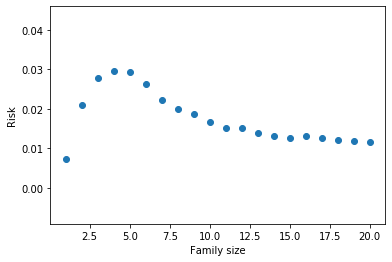

In [7]:
plt.scatter(fam_size,fam_risk)
plt.xlabel('Family size')
plt.ylabel('Risk')
plt.savefig('../images/Asymptomatic_with_testing_Modified_SEIR_1.png')
plt.show()

#### Average number of (non-zero) asymptomatics in $n_\text{iter}$ iterations per $n_\text{iter}$ vs. family size

In [8]:
# plt.scatter(fam_size,fam_mean)
# plt.xlabel('Family size')
# plt.ylabel('Mean number of (non-zero) asymptomatics')
# plt.show()

In [ ]:
for k in range (2,4):
    n_iter = 100000                      # Total iterations per family
    n_fam  = 21                          # Maximum family size

    # List of arrays to plot result ######
    fam_size = [] 
    fam_risk = []
    fam_mean = []

    #######################################


    for i in range(1,n_fam):             # loop over i (the family size)
        time_survived = []
        no_of_asymp   = []

        for j in range(0,n_iter):        # Run n_iter loops with i as family size
            t,S,E,IS,IA,R = Gil(k,i)     # Assuming 1 exposed individual initially
            time_survived.append(t[-1])  # Take last element of time array (the time survived)
            no_of_asymp.append(IA[-1])   # Take last element of IA (the final number of asymptomatics)

        time_survived = np.array(time_survived)
        no_of_asymp   = np.array(no_of_asymp)

    #     plt.scatter(time_survived,no_of_asymp)
    #     plt.show()

        non_zero_asymp = no_of_asymp[no_of_asymp!=0]  # Consider only those runs where there are 
                                                      # non-zero asymptomatics

        fam_size.append(i)                            # Set of family sizes
        fam_risk.append(len(non_zero_asymp)/n_iter)   # Total number of asymptomatics per iteration
        #fam_mean.append(np.mean(non_zero_asymp))     # Mean number of asymptomatics
        
        plt.plot(fam_size,fam_risk)